In [1]:
!mkdir -p-/.kaggle
!kaggle datasets download -d xying0613/pictures-of-animals-for-image-classification

mkdir: invalid option -- '-'
Try 'mkdir --help' for more information.
Dataset URL: https://www.kaggle.com/datasets/xying0613/pictures-of-animals-for-image-classification
License(s): unknown
pictures-of-animals-for-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/pictures-of-animals-for-image-classification.zip", 'r')
zip_ref.extractall("/content")

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import  preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.applications import VGG16

In [4]:
# Load and preprocess data
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Animals",
    seed=123,
    image_size=(224, 224),
    batch_size=1  # or your desired batch size
)

x, y = zip(*train_ds)  #changed from 1 to 64
x = tf.concat(x, axis=0)
y = tf.concat(y, axis=0)

# Get the class names from the dataset
class_names = train_ds.class_names

# Find the index corresponding to 'cats'
cat_index = class_names.index('cats')

# Create binary labels using the cat_index
y_binary = np.where(y == cat_index, 1, 0)

# Split data into training, validation, and testing sets
training_ratio = 0.7
val_ratio = 0.15  # 15% for validation
test_ratio = 0.15  # 15% for testing

num_samples = len(x)
x_train, x_val, x_test = x[:int(training_ratio * num_samples)], x[int(training_ratio * num_samples):int((training_ratio + val_ratio) * num_samples)], x[int((training_ratio + val_ratio) * num_samples):]
y_train, y_val, y_test = y_binary[:int(training_ratio * num_samples)], y_binary[int(training_ratio * num_samples):int((training_ratio + val_ratio) * num_samples)], y_binary[int((training_ratio + val_ratio) * num_samples):]


# Preprocess images
x_train_preprocessed = preprocess_input(x_train)
x_test_preprocessed = preprocess_input(x_test)
x_val_preprocessed = preprocess_input(x_val)

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#Build the Model
model = Sequential()
for layer in vgg16_base.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable = False  # Freeze VGG16 layers

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Found 5002 files belonging to 10 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,322,530 (62.27 MB)

 Trainable params: 1,607,842 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
# Compile the model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    x_train_preprocessed,
    y_train,
    validation_data=(x_val_preprocessed, y_val),
    batch_size=32,
    epochs=10
)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 66s 434ms/step - accuracy: 0.8068 - loss: 0.5283 - val_accuracy: 0.9760 - val_loss: 0.1042
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 163ms/step - accuracy: 0.9128 - loss: 0.1940 - val_accuracy: 0.9853 - val_loss: 0.0725
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.9333 - loss: 0.1765 - val_accuracy: 0.9880 - val_loss: 0.0579
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - accuracy: 0.9608 - loss: 0.1065 - val_accuracy: 0.9880 - val_loss: 0.0487
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - accuracy: 0.9530 - loss: 0.1102 - val_accuracy: 0.9893 - val_loss: 0.0456
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.9624 - loss: 0.0936 - val_accuracy: 0.9867 - val_loss: 0.0581
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.9642 - loss: 0.0908 - val_accuracy: 0.9840 - val_loss: 0.0554
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - accuracy: 0.9693 - loss: 0

In [6]:
Y_pred = model.predict(x_test_preprocessed)
print(y_test[:10])
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, Y_pred.argmax(axis=1))
print("Accuracy:", accuracy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 532ms/step
[0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.9773635153129161


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score


Y_pred = model.predict(x_test_preprocessed)
y_pred_classes = Y_pred.argmax(axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step
Precision: 0.8513513513513513
Recall: 0.9130434782608695
F1-score: 0.8811188811188811


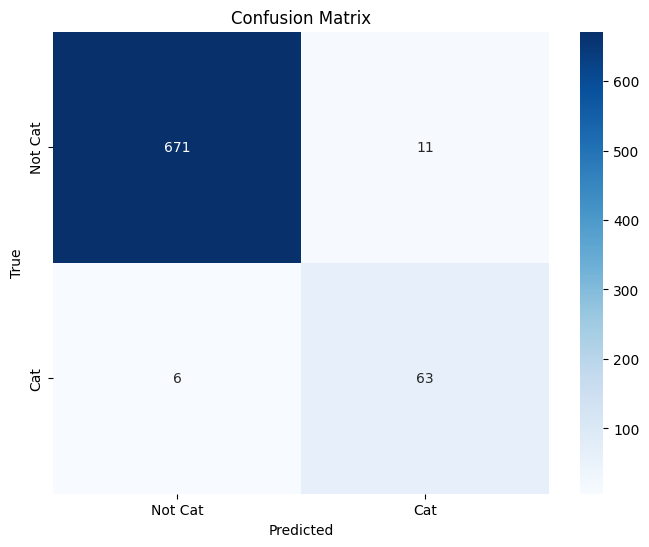

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_classes are defined from the previous code

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Cat', 'Cat'], yticklabels=['Not Cat', 'Cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix:
 [[671  11]
 [  6  63]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       682
           1       0.85      0.91      0.88        69

    accuracy                           0.98       751
   macro avg       0.92      0.95      0.93       751
weighted avg       0.98      0.98      0.98       751



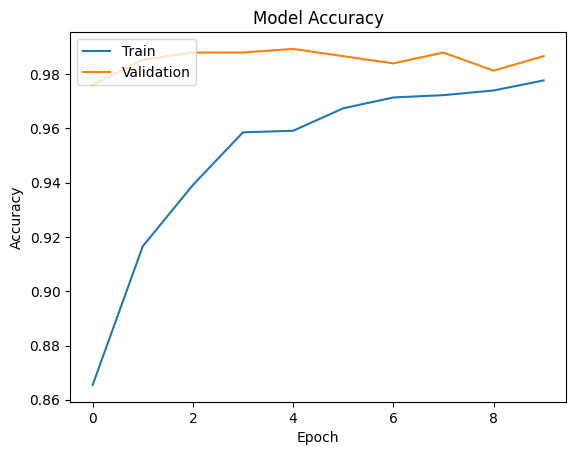

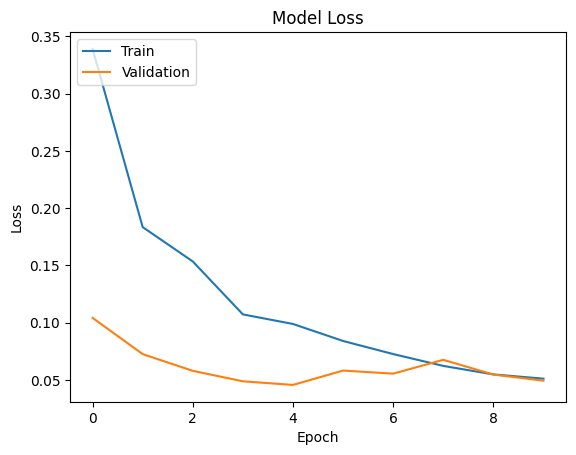

In [9]:
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test, y_pred_classes)  # Use y_pred_classes instead of predicted_classes
print("Confusion Matrix:\n", cm)

cr = classification_report(y_test, y_pred_classes)  # Use y_pred_classes instead of predicted_classes
print("Classification Report:\n", cr)

# Step 12: Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
model.save('/content/model.h5')

 model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class index for /content/download.jpeg: 1
Predicted class name for /content/download.jpeg: cat


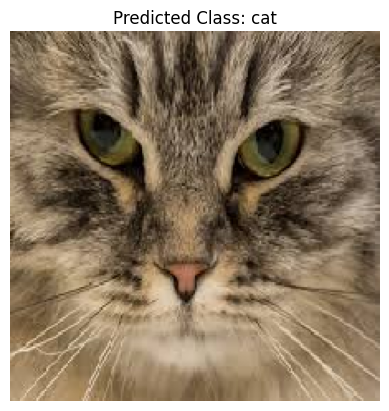

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class index for /content/download (1).jpeg: 0
Predicted class name for /content/download (1).jpeg: not cat


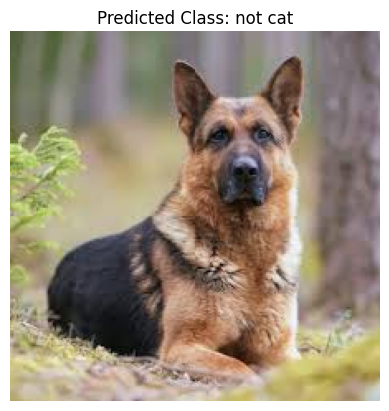

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class index for /content/download (2).jpeg: 0
Predicted class name for /content/download (2).jpeg: not cat


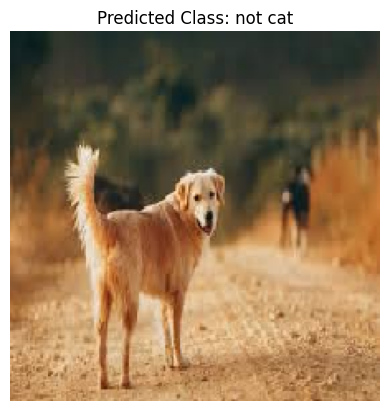

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class index for /content/download (3).jpeg: 0
Predicted class name for /content/download (3).jpeg: not cat


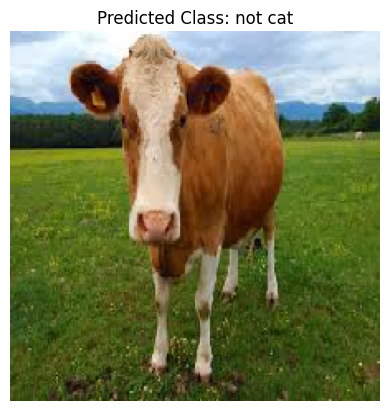

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class index for /content/download (4).jpeg: 0
Predicted class name for /content/download (4).jpeg: not cat


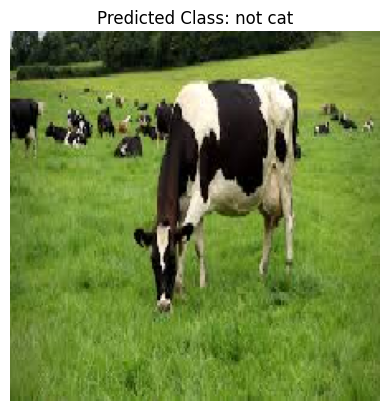

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class index for /content/images (1).jpeg: 1
Predicted class name for /content/images (1).jpeg: cat


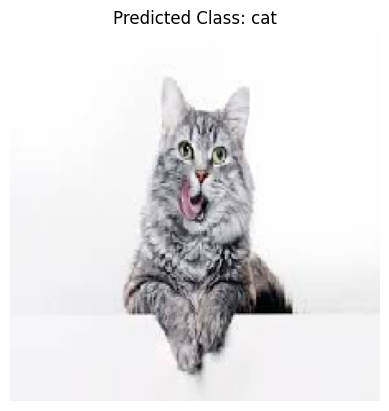

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class index for /content/images.jpeg: 0
Predicted class name for /content/images.jpeg: not cat


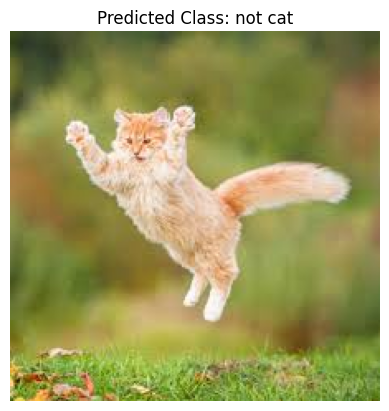

In [14]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load the saved ResNet152V2 model
model = load_model('/content/model.h5')  # Update with your model path
print(" model loaded successfully!")

# List of test image paths (update with your image paths)
test_image_paths = [
    '/content/download.jpeg',
    '/content/download (1).jpeg',
    '/content/download (2).jpeg',
    '/content/download (3).jpeg',
    '/content/download (4).jpeg',
    '/content/images (1).jpeg',
    '/content/images.jpeg'
]

# Define class labels (update with your actual labels)
class_labels = ['not cat', 'cat']

# Function to process and predict each image
for image_path in test_image_paths:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Resize to 224x224
    img_array = img_to_array(img)  # Convert to array
    img_array = preprocess_input(img_array)  # Apply ResNet152V2 preprocessing
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the label of the test image
    predictions = model.predict(img_array)

    # Get the index of the predicted class
    predicted_class = np.argmax(predictions)
    print(f"Predicted class index for {image_path}: {predicted_class}")

    # Map the predicted index to the class name
    predicted_class_name = class_labels[predicted_class]
    print(f"Predicted class name for {image_path}: {predicted_class_name}")

    # Display the test image with the predicted label
    plt.figure()
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class_name}")
    plt.axis('off')
    plt.show()
